# Exploratory Data Analysis

## Initial Settings

### Roots and Paths

In [152]:
import sys
from pathlib import Path

# Ruta a la raíz del proyecto
project_root = Path().resolve().parent
sys.path.append(str(project_root))

### Libraries and Dependencies

In [153]:
import src.utils as ut
import src.config as cf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from IPython.display import display
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


pd.options.display.max_columns = None
sns.set_style('dark')
sns.set_palette('dark')

### Data Loading

In [154]:
df = ut.load_data(cf.raw_data_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [155]:
target = 'Churn'

## Preliminary EDA

### Basic Information

In [156]:
# dataset size
print(f'Dimensions: {df.shape}')

# summary table
ut.summary_info(df)

Dimensions: (7043, 21)


Column,Non-Null Count,Missing %,Unique Values,Data Type
customerID,"7,043",0.000000,"7,043",object
DeviceProtection,"7,043",0.000000,3,object
TotalCharges,"7,043",0.000000,"6,531",object
MonthlyCharges,"7,043",0.000000,"1,585",float64
PaymentMethod,"7,043",0.000000,4,object
PaperlessBilling,"7,043",0.000000,2,object
Contract,"7,043",0.000000,3,object
StreamingMovies,"7,043",0.000000,3,object
StreamingTV,"7,043",0.000000,3,object
TechSupport,"7,043",0.000000,3,object


### Missing Values

In [157]:
ut.missing_values_by_pivot(df, return_type = 'percentage',percentage_base = 'total') 

,Missing %
customerID,0.0
gender,0.0
SeniorCitizen,0.0
Partner,0.0
Dependents,0.0
tenure,0.0
PhoneService,0.0
MultipleLines,0.0
InternetService,0.0
OnlineSecurity,0.0


### Preliminary Preprocessing

In [158]:
# drop ID column
df = df.drop('customerID', axis = 1)

# impute numerical columns with strings in them
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace = True)

## Feature - Target Relevance Analysis

### Numerical Features Relevance

#### Feature - Target Correlations

In [159]:
# peak at unique target values
print(df[target].unique())

['No' 'Yes']


In [160]:
# encoding of target
df['target_encoded'] = df[target].map({'Yes': 1, 'No': 0})

# target - numeric correlations
correlations = df.select_dtypes(include = ['float64', 'int64']).corrwith(df['target_encoded'])
correlations = correlations.sort_values(ascending = False)

# show
print('Target Correlations:')
correlations_table = pd.DataFrame(correlations, columns = ['Correlation'])
correlations_table

Target Correlations:


,Correlation
target_encoded,1.000000
MonthlyCharges,0.193356
SeniorCitizen,0.150889
TotalCharges,-0.199037
tenure,-0.352229


#### Feature - Target Correlation Visualization

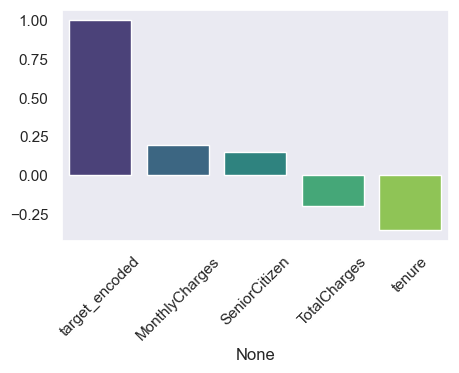

In [161]:
plt.figure(figsize = (5, 3))
sns.barplot(
    x = correlations.index, 
    y = correlations.values, 
    palette = 'viridis',
    hue = correlations.index,
    dodge = False)
plt.xticks(rotation = 45)
plt.show()

#### ANOVA Revelance Analysis

Numerical Features with p-value below 0.05 are more significant. This is modeled through a F-Statistic that measures the difference between groups in the target variable, relative to the inner dispersion

In [162]:
numerical_cols = df.select_dtypes(include = ['int64', 'float64']).drop(columns = ['target_encoded'], errors = 'ignore').columns

anova_results = []

for col in numerical_cols:
    # create groups based on target categories
    groups = [df[df['target_encoded'] == category][col] for category in df['target_encoded'].unique()]
    
    # calculate F-statistic and p-value
    f_stat, p_value = f_oneway(*groups)
    
    # save results in a dictionary
    anova_results.append({'Feature': col, 'F-Statistic': f_stat, 'P-Value': p_value})

# convert results to DataFrame
anova_table = pd.DataFrame(anova_results)

# formatting
anova_table = anova_table.sort_values(by = 'P-Value', ascending = False)

anova_table.style.format({
    'F-Statistic': '{:.2f}',
    'P-Value': '{:.3f}'
})

anova_table
    

,Feature,F-Statistic,P-Value
0,SeniorCitizen,164.041424,3.839860e-37
2,MonthlyCharges,273.463704,2.706646e-60
3,TotalCharges,290.439831,7.508609e-64
1,tenure,997.268010,7.999058e-205


### Categorical Features Relevance

#### Categorical Features Selection

In [163]:
cat_columns = list(set(df.columns) - set(numerical_cols))

cat_columns.remove('target_encoded')
cat_columns.remove(target)

#### Chi - Squared Test

In [164]:
chi2_results = []

for col in cat_columns:
    # contigency table
    contingency_table = pd.crosstab(df[col], df[target])
    
    # chi-squared
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # append results
    chi2_results.append({'Feature': col, 'Chi2': chi2, 'P-Value': p})
    
# formatting
chi2_df = pd.DataFrame(chi2_results).sort_values(by = 'Chi2', ascending = False)

chi2_df.style.format({
    'Chi2': '{:.2f}',
    'P-Value': '{:.3f}'
})

chi2_df

,Feature,Chi2,P-Value
11,Contract,1184.596572,5.863038e-258
1,OnlineSecurity,849.998968,2.661150e-185
7,TechSupport,828.197068,1.443084e-180
13,InternetService,732.309590,9.571788e-160
4,PaymentMethod,648.142327,3.682355e-140
9,OnlineBackup,601.812790,2.079759e-131
14,DeviceProtection,558.419369,5.505219e-122
8,StreamingMovies,375.661479,2.667757e-82
10,StreamingTV,374.203943,5.528994e-82
5,PaperlessBilling,258.277649,4.073355e-58


### Feature Ranking

##### Preliminary Preprocessing

In [165]:
df_encoded = df.copy()

for col in cat_columns:
    encoder = LabelEncoder()
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

df_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,target_encoded
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,No,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,No,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,Yes,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,No,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,Yes,1


##### Target - Feature Split

In [166]:
X = df_encoded.drop([target, 'target_encoded'], axis = 1)
y = df_encoded['target_encoded']

##### Simple Random Forest Fit

In [167]:
model = RandomForestClassifier(random_state = 123, n_estimators = 100)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False)

##### Ranking Table

In [168]:
importance_df = pd.DataFrame({
    'Feature': feature_importance.index,
    'Importance': feature_importance.values
}).sort_values(by = 'Importance', ascending = False)

importance_df

,Feature,Importance
0,TotalCharges,0.192884
1,MonthlyCharges,0.177583
2,tenure,0.153465
3,Contract,0.081426
4,PaymentMethod,0.050812
5,TechSupport,0.045465
6,OnlineSecurity,0.043400
7,InternetService,0.028337
8,gender,0.028258
9,OnlineBackup,0.026109


##### Ranking Visualization

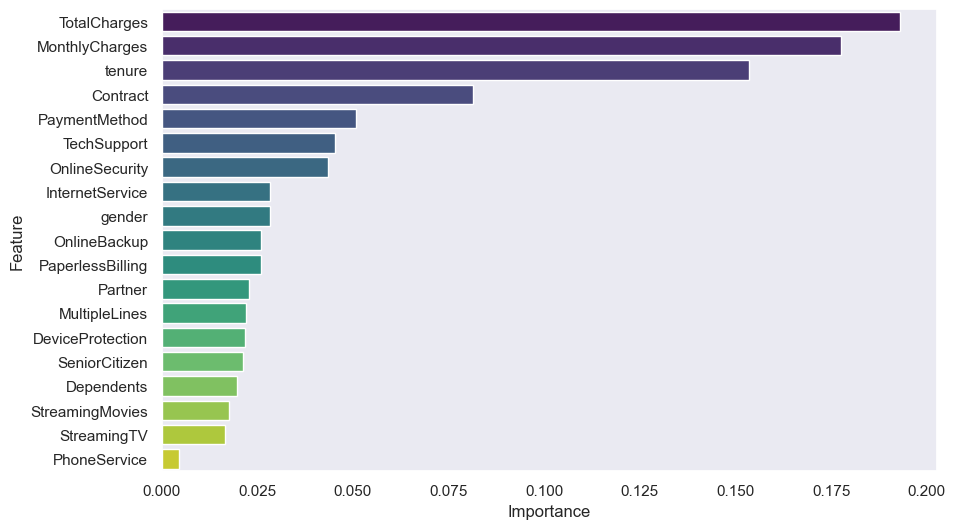

In [169]:
plt.figure(figsize = (10, 6))

sns.barplot(
    x = 'Importance', 
    y = 'Feature', 
    data = importance_df, 
    palette = 'viridis',
    hue = 'Feature',
    dodge = False)
plt.show()

### Relevant Feature Selection

In [170]:
relevant_num_cols = [
    'TotalCharges',
    'MonthlyCharges',
    'tenure'
]

relevant_cat_cols = [
    'Contract',
    'OnlineSecurity',
    'PaymentMethod',
    'TechSupport',
    'OnlineBackup'
]

## Numerical Feature Analysis

### Statistical Summary

In [171]:
# statistical summary
df.describe().applymap(lambda x: ut.format_cell(x)).style.applymap(ut.center_align)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,target_encoded
count,"7,043","7,043","7,043","7,043","7,043"
mean,0.16,32.37,64.76,"2,281.92",0.27
std,0.37,24.56,30.09,"2,265.27",0.44
min,0,0,18.25,18.80,0
25%,0,9,35.50,402.23,0
50%,0,29,70.35,"1,397.47",0
75%,0,55,89.85,"3,786.60",1
max,1,72,118.75,"8,684.80",1


### Histograms

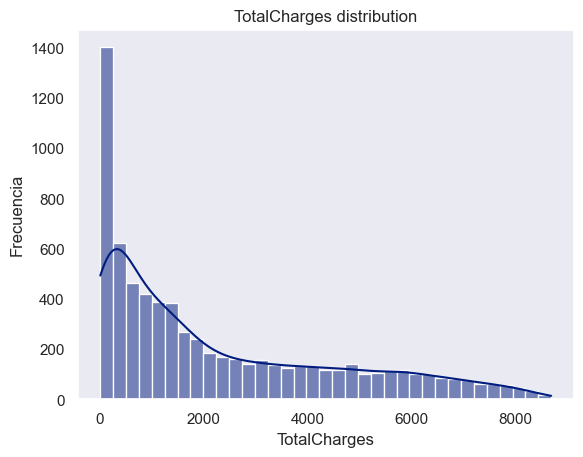

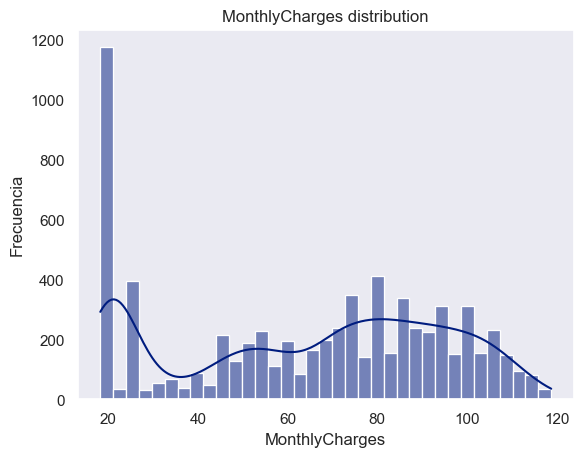

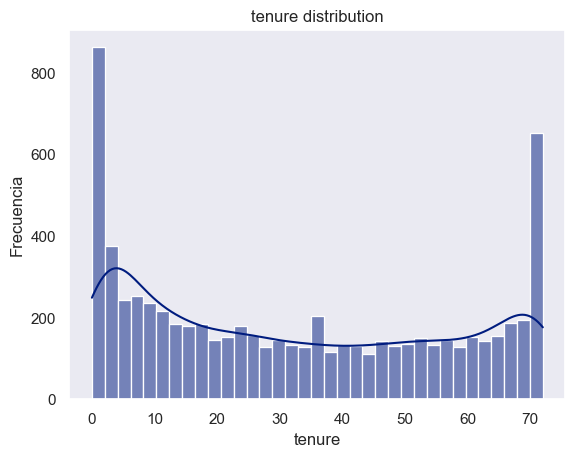

In [172]:
# create histogram and density curves

for col in relevant_num_cols:
    sns.histplot(df[col], kde = True, bins = 35)
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

### Box Plots

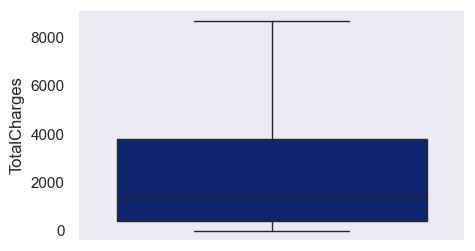

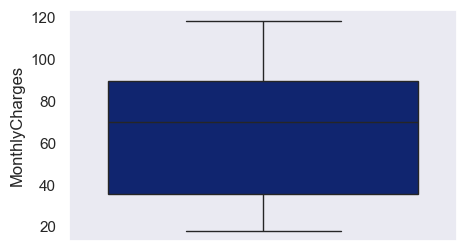

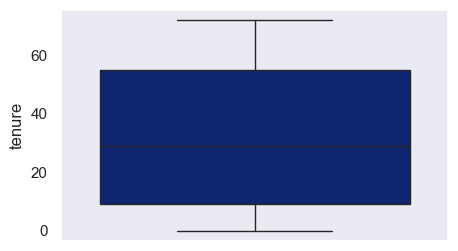

In [173]:
for col in relevant_num_cols:
    plt.figure(figsize = (5, 3))
    sns.boxplot(y = df[col])
    plt.ylabel(col)
    plt.show()

### Pair Plots

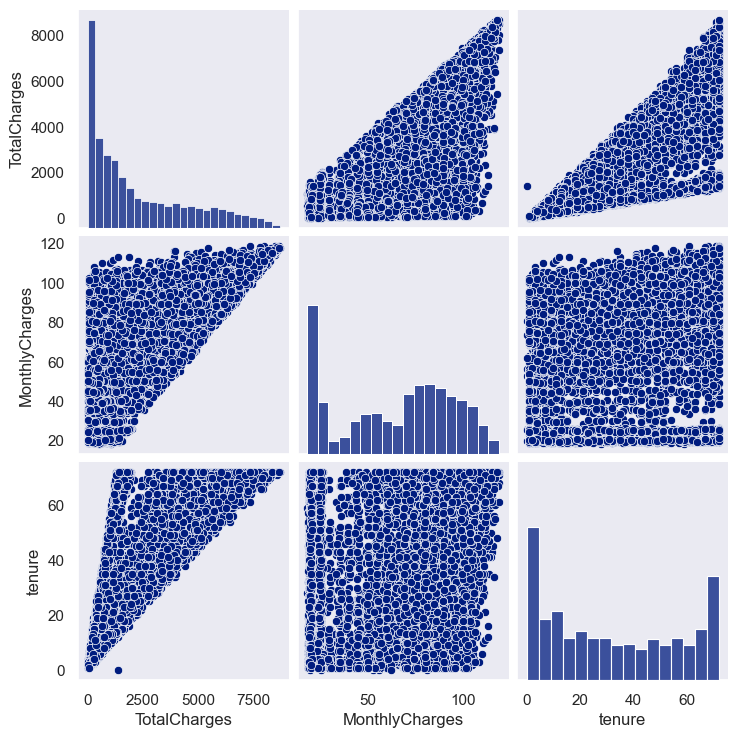

In [174]:
sns.pairplot(df[relevant_num_cols])
plt.show()

### Heatmap

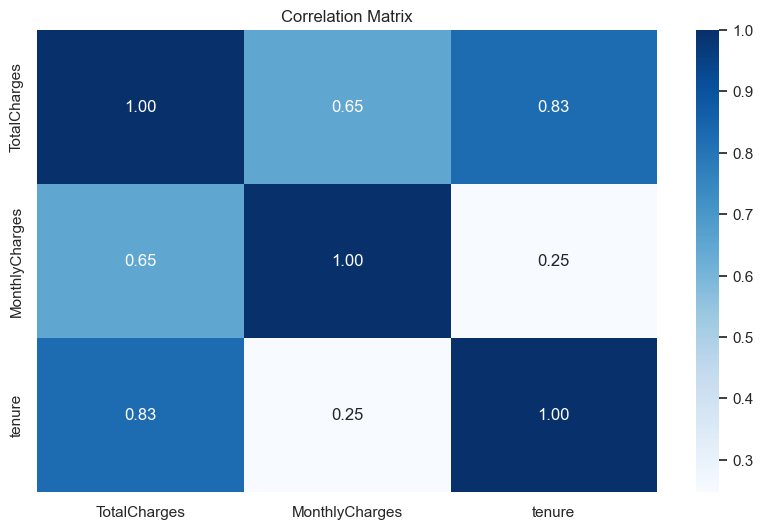

In [175]:
correlation_matrix = df[relevant_num_cols].corr()
plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues', cbar = True)
plt.title('Correlation Matrix')
plt.show()

## Categorical Feature Analysis

### Uniqueness

In [176]:
ut.uniqueness_categorical_columns(df, max_categories = 10)

--- Column: gender ---
Unique values: 2


Category,Percentage
Male,50.48%
Female,49.52%




--- Column: Partner ---
Unique values: 2


Category,Percentage
No,51.70%
Yes,48.30%




--- Column: Dependents ---
Unique values: 2


Category,Percentage
No,70.04%
Yes,29.96%




--- Column: PhoneService ---
Unique values: 2


Category,Percentage
Yes,90.32%
No,9.68%




--- Column: MultipleLines ---
Unique values: 3


Category,Percentage
No,48.13%
Yes,42.18%
No phone service,9.68%




--- Column: InternetService ---
Unique values: 3


Category,Percentage
Fiber optic,43.96%
DSL,34.37%
No,21.67%




--- Column: OnlineSecurity ---
Unique values: 3


Category,Percentage
No,49.67%
Yes,28.67%
No internet service,21.67%




--- Column: OnlineBackup ---
Unique values: 3


Category,Percentage
No,43.84%
Yes,34.49%
No internet service,21.67%




--- Column: DeviceProtection ---
Unique values: 3


Category,Percentage
No,43.94%
Yes,34.39%
No internet service,21.67%




--- Column: TechSupport ---
Unique values: 3


Category,Percentage
No,49.31%
Yes,29.02%
No internet service,21.67%




--- Column: StreamingTV ---
Unique values: 3


Category,Percentage
No,39.90%
Yes,38.44%
No internet service,21.67%




--- Column: StreamingMovies ---
Unique values: 3


Category,Percentage
No,39.54%
Yes,38.79%
No internet service,21.67%




--- Column: Contract ---
Unique values: 3


Category,Percentage
Month-to-month,55.02%
Two year,24.07%
One year,20.91%




--- Column: PaperlessBilling ---
Unique values: 2


Category,Percentage
Yes,59.22%
No,40.78%




--- Column: PaymentMethod ---
Unique values: 4


Category,Percentage
Electronic check,33.58%
Mailed check,22.89%
Bank transfer (automatic),21.92%
Credit card (automatic),21.61%




--- Column: Churn ---
Unique values: 2


Category,Percentage
No,73.46%
Yes,26.54%


### Count Plot

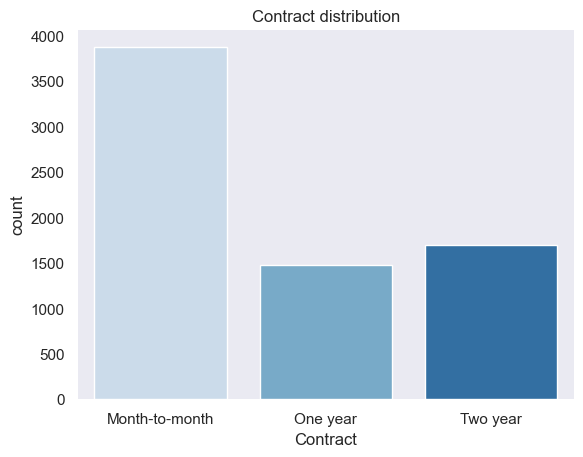

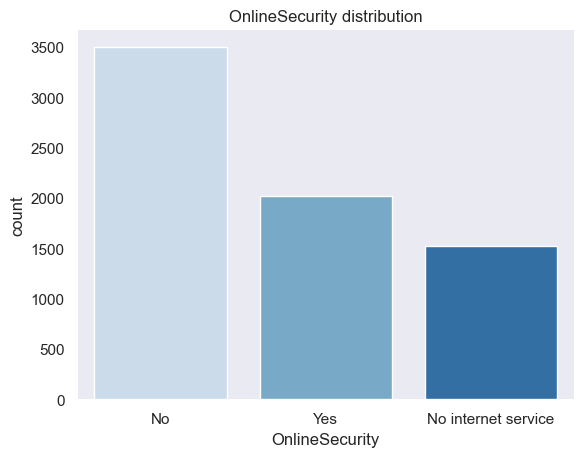

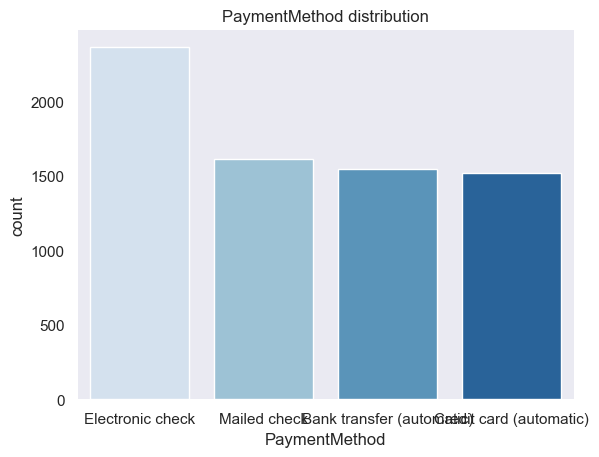

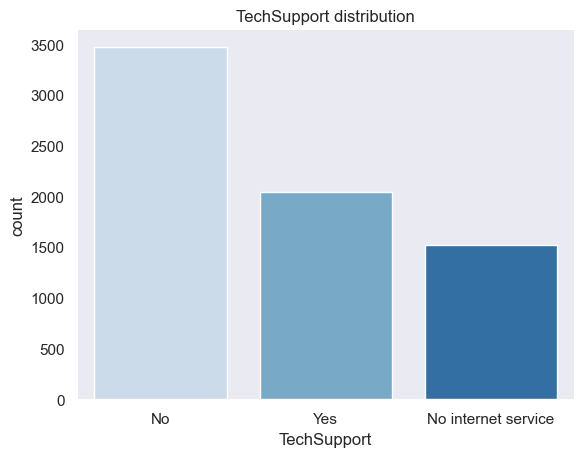

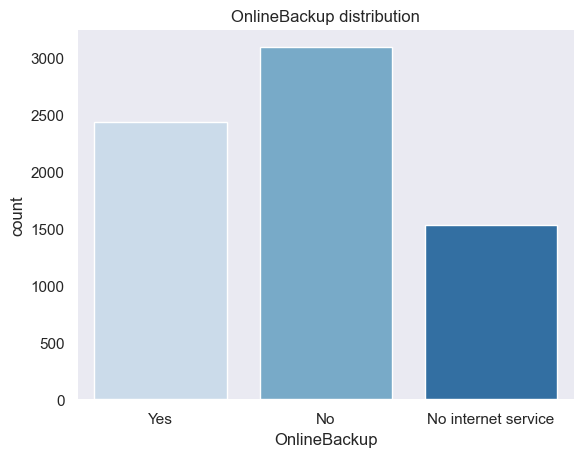

In [177]:
for col in relevant_cat_cols:
    sns.countplot(x = col, data = df, palette = 'Blues', hue = col)
    plt.title(f'{col} distribution')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

### Crosstabs

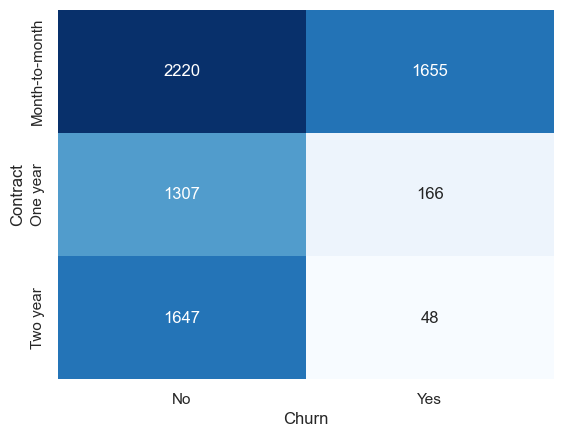

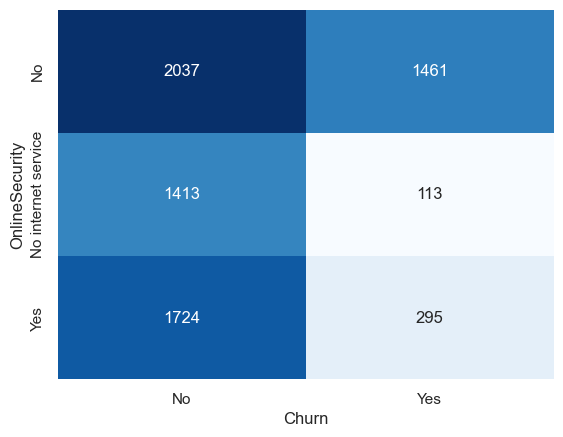

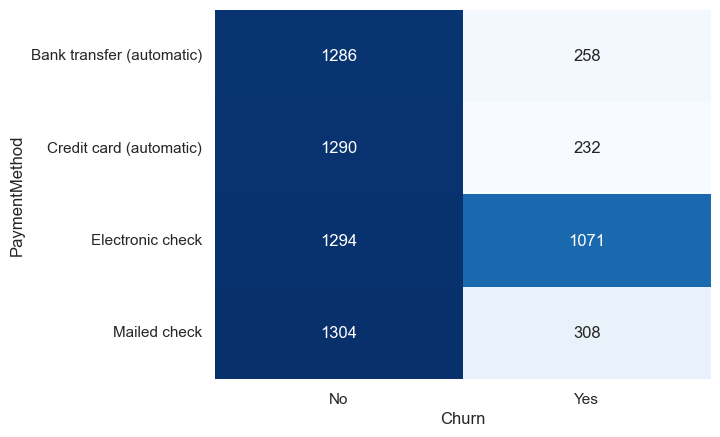

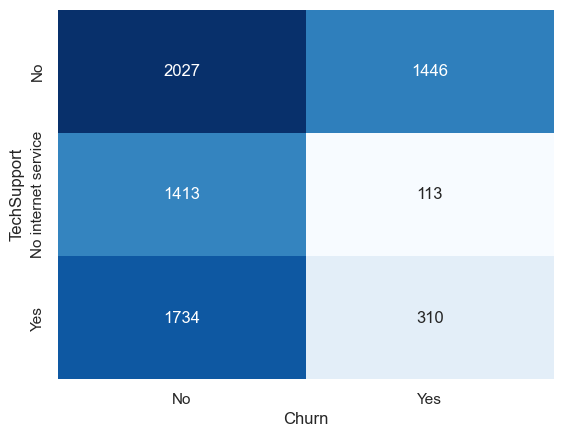

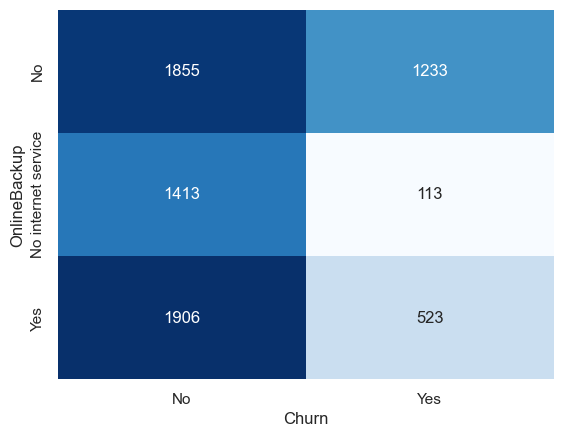

In [178]:
for col in relevant_cat_cols:
    cross = pd.crosstab(df[col], df['Churn'])

    sns.heatmap(cross, annot = True, fmt = 'd', cmap = 'Blues', cbar= False)
    plt.show()

<Axes: xlabel='Churn', ylabel='Contract-PaymentMethod'>

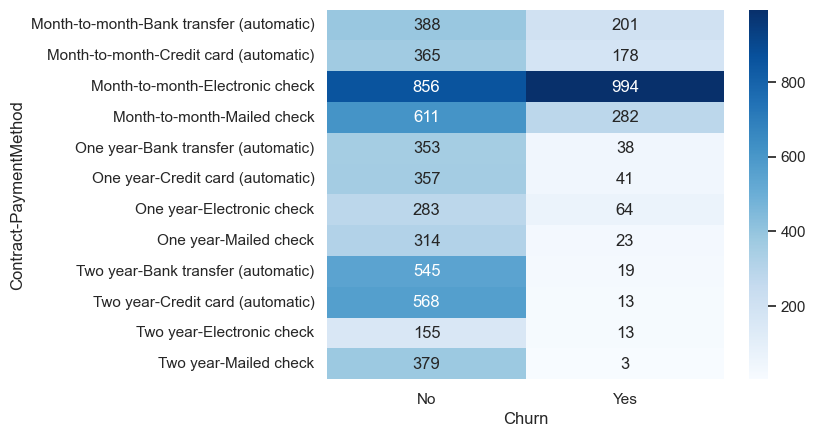

In [179]:
contract_churn = pd.crosstab([df['Contract'], df["PaymentMethod"]], df['Churn'])

sns.heatmap(contract_churn, annot = True, fmt = 'd', cmap = 'Blues')

## Cross-Variable Feature Analysis

### Swarm Plots

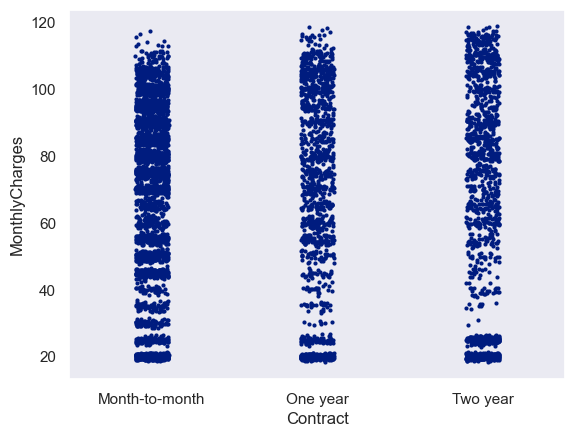

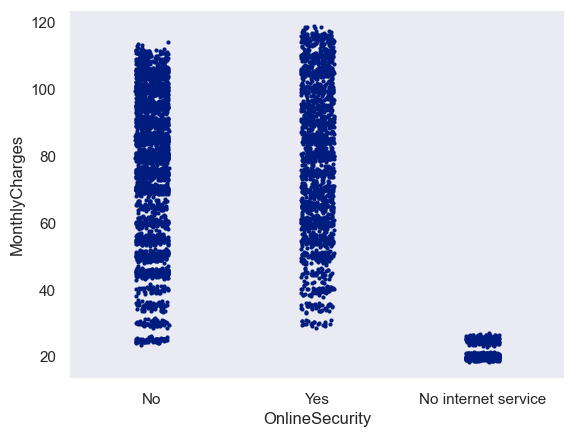

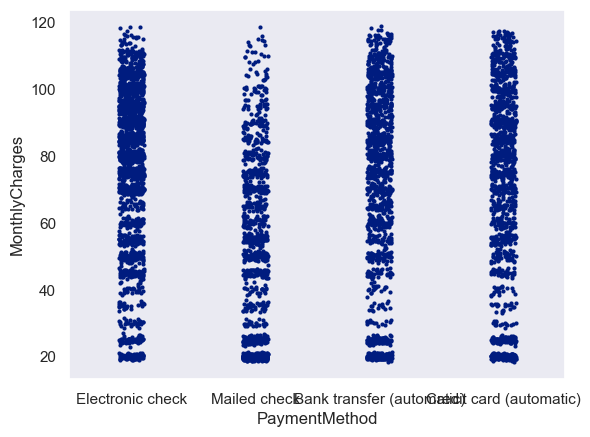

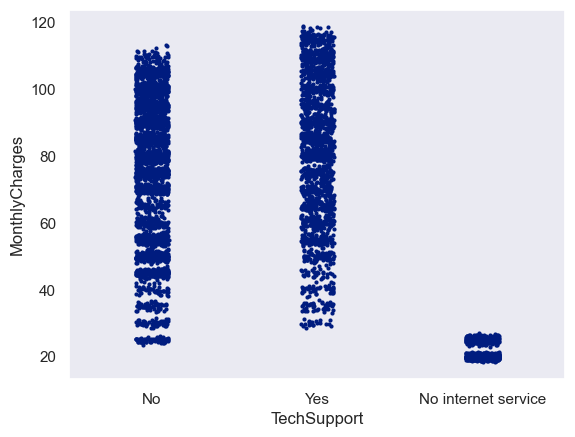

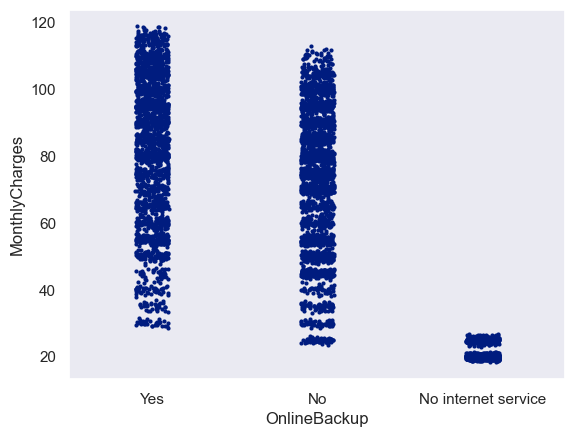

In [180]:
for col in relevant_cat_cols:  
    sns.stripplot(x = col, y ='MonthlyCharges', data = df, size = 3)
    plt.show()

### Catplots

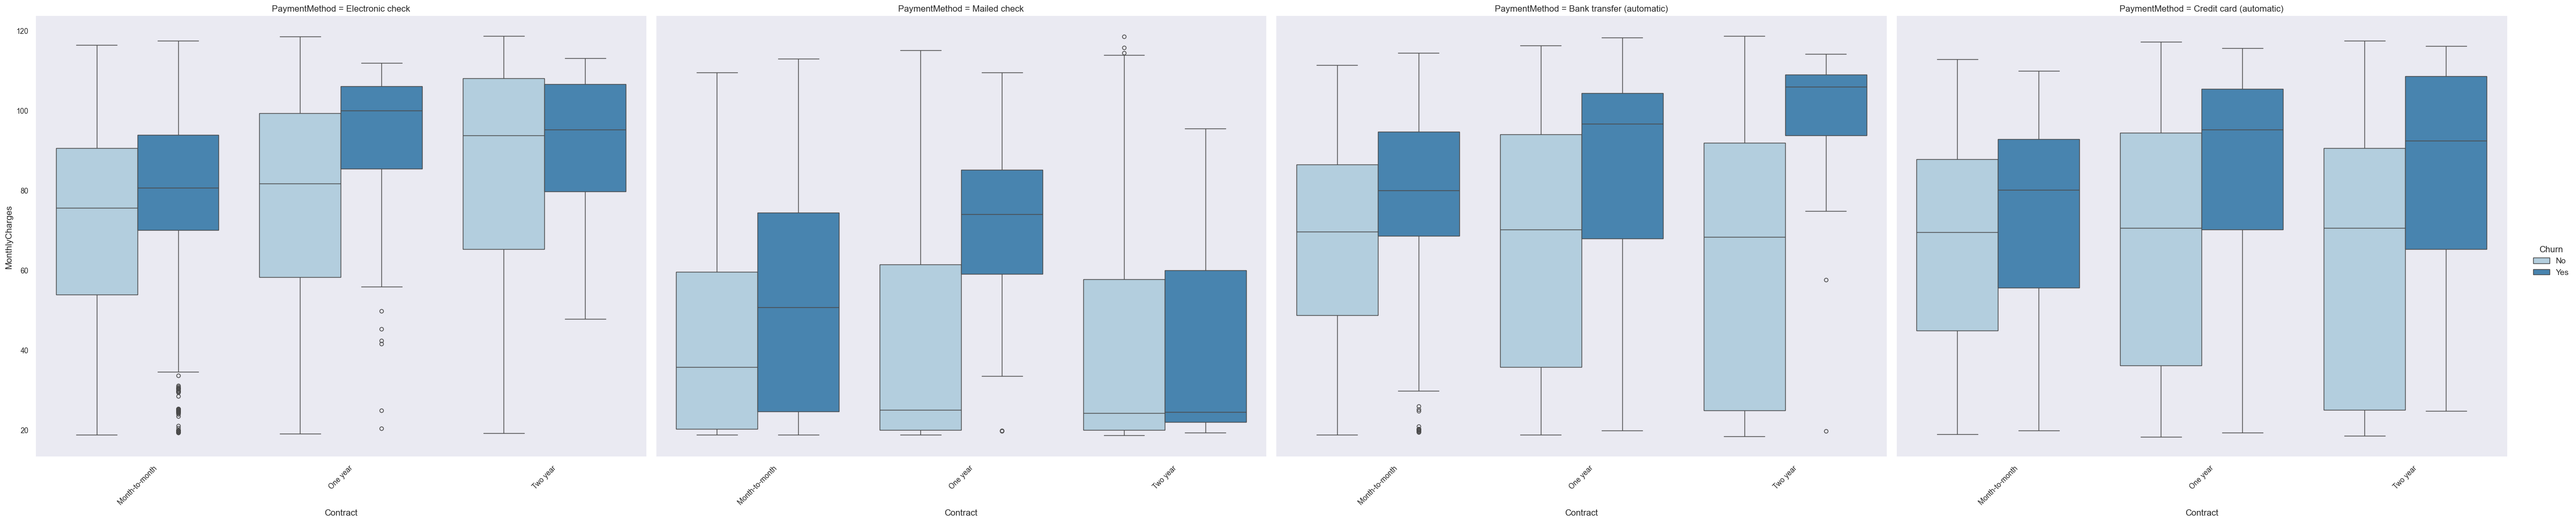

In [181]:
g = sns.catplot(
    x = 'Contract', 
    y = 'MonthlyCharges', 
    hue = 'Churn', 
    col = 'PaymentMethod', 
    kind = 'box', 
    data = df,
    palette = 'Blues',
    height= 10,
    aspect = 1.2
    )


for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    


g.fig.subplots_adjust(top = 0.9)
plt.show()

### Scatter Plot

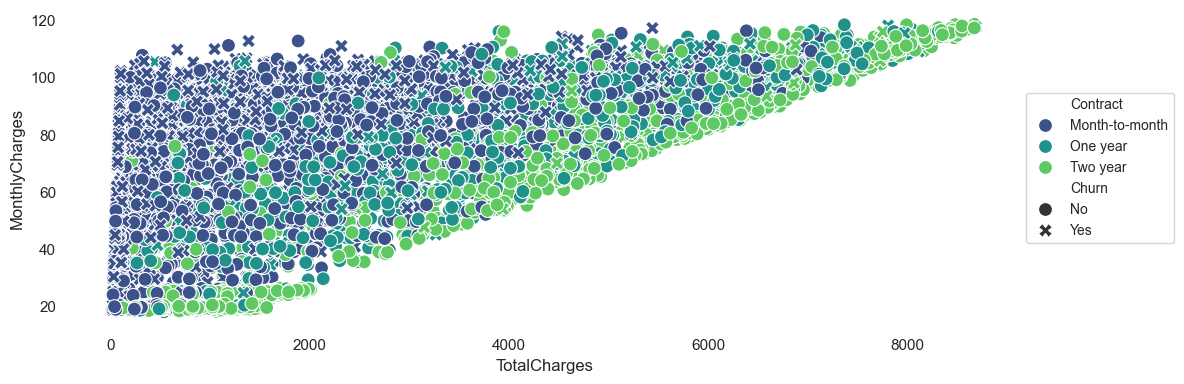

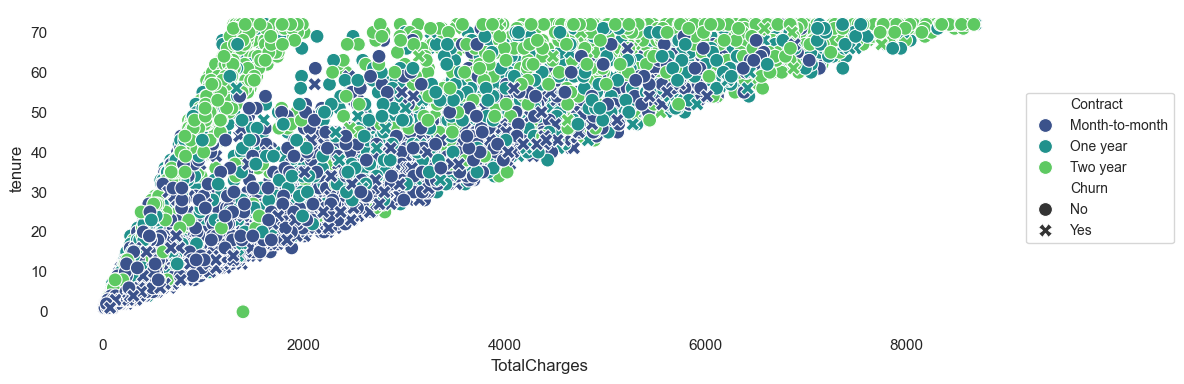

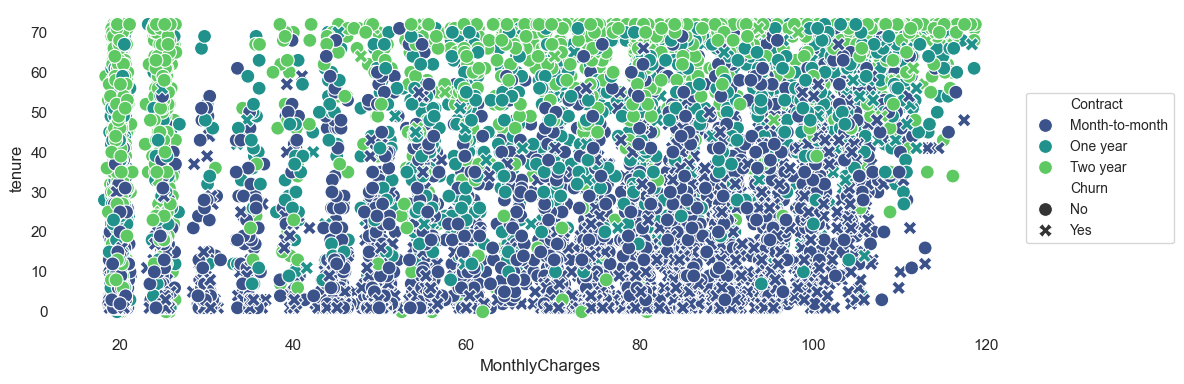

In [182]:
sns.set_theme(style = 'white')

pairs = list(itertools.combinations(relevant_num_cols, 2))

for x_var, y_var in pairs:
    plt.figure(figsize = (12, 4))
    sns.scatterplot(
        x = x_var, 
        y = y_var, 
        hue = 'Contract', 
        style = 'Churn', 
        data = df,
        palette = 'viridis',
        s = 100
        )
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

### Categorical Line Plots

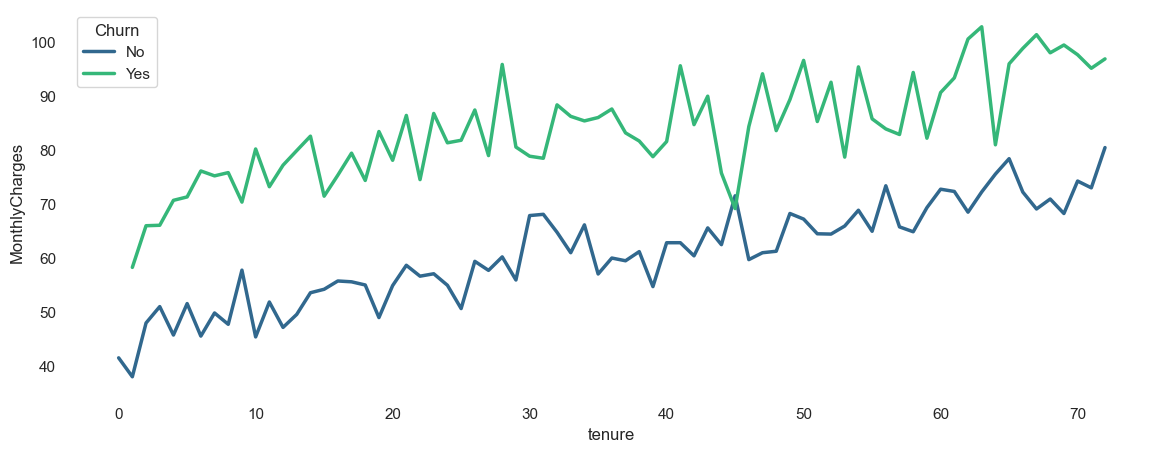

In [183]:
plt.figure(figsize = (14, 5))

sns.lineplot(
    x = 'tenure', 
    y ='MonthlyCharges', 
    hue = 'Churn', 
    data = df, 
    errorbar = None,
    palette = 'viridis',
    linewidth = 2.5
    )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Stacked Histograms

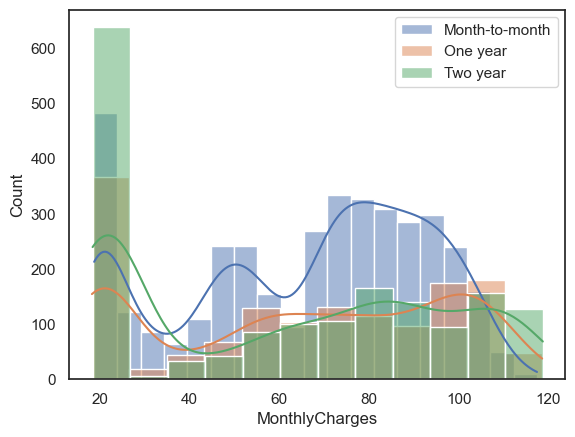

In [184]:
for contract in df['Contract'].unique():
    subset = df[df['Contract'] == contract]
    sns.histplot(subset['MonthlyCharges'], label = contract, kde = True, alpha = 0.5)
plt.legend()
plt.show()

### Interactions Heatmap

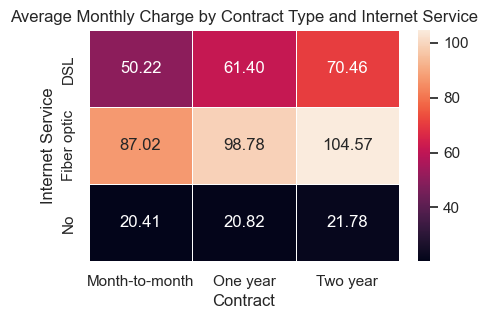

In [185]:
pivot_table = pd.pivot_table(
    df,
    values = 'MonthlyCharges',
    index = 'InternetService',
    columns = 'Contract',
    aggfunc = 'mean'   
)

plt.figure(figsize = (5, 3))
sns.heatmap(pivot_table, annot = True, fmt = '.2f', linewidths = 0.5)
plt.title('Average Monthly Charge by Contract Type and Internet Service')
plt.xlabel('Contract')
plt.ylabel('Internet Service')
plt.show()